# Two-body Gravitational Problem using Lagrange's equation

Defines a LagrangianTwoBody class that is used to generate basic orbit plots from solving Lagrange's equations. Based of the Langraian_pendulum notebook and LagrangianPendulum class both by Dick Furhstahl (furnstahl.1@osu.edu).

## Euler-Lagrange equation

For a two-body gravitational problem, the Lagrangian with generalized coordinates $x_1$, $y_1$, $x_2$ and $y_2$ is

$\begin{align}
  \mathcal{L} = \frac12 m_1 \dot x_1^2 + \frac12 m_1 \dot y_1^2 + \frac12 m_2 \dot x_2^2 + \frac12 m_2 \dot y_2^2 + \frac{Gm_1m_2}{\sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}}
\end{align}$

The Euler-Lagrange equations are:

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot x_1} = \frac{\partial\mathcal L}{\partial x_1}
 \quad\Longrightarrow\quad
 \ddot x_1= \frac{m_2G(x_2-x_1)}{((x_1-x_2)^2+(y_1-y_2)^2)^\frac32}
  \;
\end{align}$

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot y_1} = \frac{\partial\mathcal L}{\partial y_1}
 \quad\Longrightarrow\quad
 \ddot y_1= \frac{m_2G(y_2-y_1)}{((x_1-x_2)^2+(y_1-y_2)^2)^\frac32}
  \;
\end{align}$

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot x_2} = \frac{\partial\mathcal L}{\partial x_2}
 \quad\Longrightarrow\quad
 \ddot x_2= \frac{m_1G(x_1-x_2)}{((x_1-x_2)^2+(y_1-y_2)^2)^\frac32}
  \;
\end{align}$

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot y_2} = \frac{\partial\mathcal L}{\partial y_2}
 \quad\Longrightarrow\quad
 \ddot y_2= \frac{m_1G(y_1-y_2)}{((x_1-x_2)^2+(y_1-y_2)^2)^\frac32}
  \;
\end{align}$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Two-Body class and utility functions

In [4]:
class LagrangianTwoBody():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a two-body gravity problem.
     
    Parameters
    ----------
    
    G : float
        gravitational constant
    m_1 : float
        mass of the first body
    m_2 : float
        mass of the second body

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, G=1., m_1=1., m_2=2.,
                ):
        self.G = G
        self.m_1 = m_1
        self.m_2 = m_2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dx_1/dt d^2x_1/dt^2 dy_1/dt d^2y_1/dt^2 dx_2/dt d^2x_2/dt^2 dy_2/dt d^2y_2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 8-component vector with y[0] = x_1(t) and y[1] = dx_1/dt y[2] = y_1(t) and y[3] = dy_1/dt
                                      y[4] = x_2(t) and y[5] = dx_2/dt y[6] = y_2(t) and y[7] = dy_2/dt
            
        Returns
        -------
        
        """
        #Solve for that common denominator once
        Dnm = ((y[0]-y[4])**2 + (y[2]-y[6])**2)**(3/2)
        
        return [y[1], (self.m_2*self.G*(y[4]-y[0]))/Dnm, y[3], (self.m_2*self.G*(y[6]-y[2]))/Dnm, y[5], \
               (self.m_1*self.G*(y[0]-y[4]))/Dnm, y[7], (self.m_1*self.G*(y[2]-y[6]))/Dnm]
    
    def solve_ode(self, t_pts, x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, x_2_0, x_2_dot_0, y_2_0, y_2_dot_0,
                  abserr=1.0e-6, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, x_2_0, x_2_dot_0, y_2_0, y_2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot = solution.y

        return x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make simple orbit plots 

In [7]:
# Labels for individual plot axes
x_vs_y_labels = (r'x', r'y')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 1.
mass_1 = 10.
mass_2 = 4.

# Instantiate a pendulum 
o1 = LagrangianTwoBody(G=G,m_1=mass_1,m_2=mass_2)

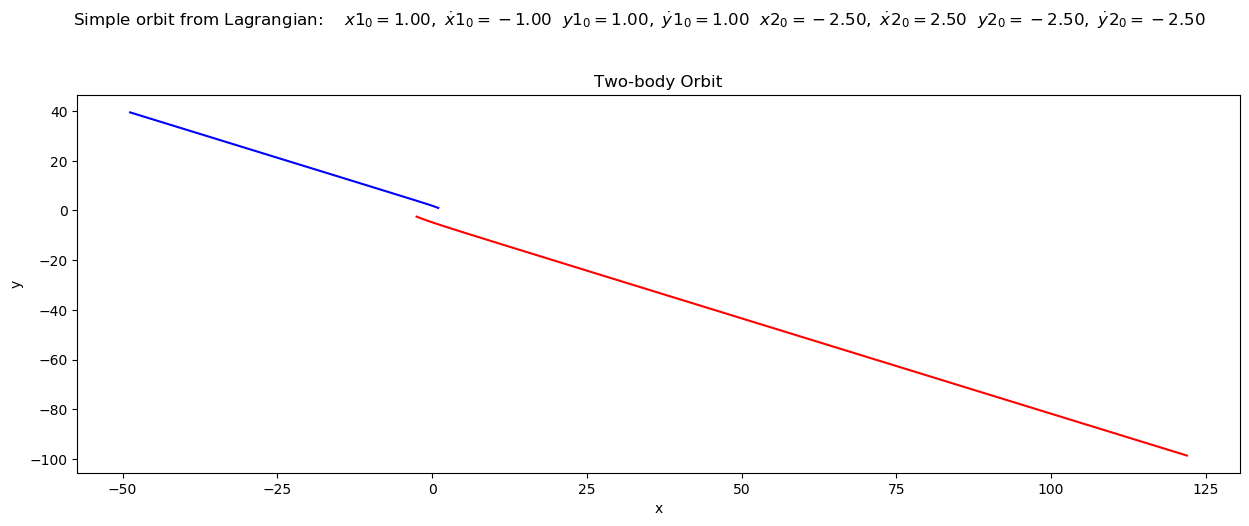

In [8]:
# Set initial conditions
x_1_0 = 1.
x_1_dot_0 = -1.
y_1_0 = 1.
y_1_dot_0 = 1.

x_2_0 = (-mass_1/mass_2)*x_1_0
x_2_dot_0 = (-mass_1/mass_2)*x_1_dot_0
y_2_0 = (-mass_1/mass_2)*y_1_0
y_2_dot_0 = (-mass_1/mass_2)*y_1_dot_0

#Solve the differential equations
x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot = o1.solve_ode(t_pts, x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, \
                                                                      x_2_0, x_2_dot_0, y_2_0, y_2_dot_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Simple orbit from Lagrangian:  ' + \
                rf'  $x 1_0 = {x_1_0:.2f},$' + \
                rf' $\dot x 1_0 = {x_1_dot_0:.2f}$' + \
                rf'  $y 1_0 = {y_1_0:.2f},$' + \
                rf' $\dot y 1_0 = {y_1_dot_0:.2f}$' + \
                rf'  $x 2_0 = {x_2_0:.2f},$' + \
                rf' $\dot x 2_0 = {x_2_dot_0:.2f}$' + \
                rf'  $y 2_0 = {y_2_0:.2f},$' + \
                rf' $\dot y 2_0 = {y_2_dot_0:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x_1[start : stop], y_1[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label=None, 
            title=None, 
            ax=ax_a)    
                              
plot_y_vs_x(x_2[start : stop], y_2[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label=None, 
            title='Two-body Orbit', 
            ax=ax_a)
    
    
fig.savefig('two_body_Lagrange.png', bbox_inches='tight')  

Last time I checked, that is not how gravity works. I am currently debugging it